In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(linewidth=140)
import pandas as pd; pd.set_option('display.width', 160)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
import datetime as dt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchinfo


set torch.multiprocessing.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example command line for training
```bash
# alternative_imputation.
python train_schrodinger_bridge.py --problem-name pm25 --forward-net Unetv2 --backward-net Transformerv2 \
    --train-method alternate_imputation_v2 --num-stage 20 --num-epoch 6 --num-itr 80 --samp-bs 1000 --train-bs-x 10 --train-bs-t 10 \
    --DSM-warmup --dsm-train-method dsm_imputation_v2 --num-itr-dsm 12000 --train-bs-x-dsm 64 --train-bs-t-dsm 1 --backward-warmup-epoch 50 \
    --sde-type ve --t0 0.001 --sigma-min 0.001 --sigma-max 20 --interval 100 \
    --lr-dsm 1e-3 --lr-b 5e-6 --lr-f 1e-6 --l2-norm 1e-6 --grad-clip 1 --lr-step 300 \
    --num-eval-sample 100 --imputation-eval --eval-impute-function imputation \
    --notes 'backward_cnt' --gpu 3
```

In [ ]:
import options

problem_name = 'pm25'
opt = options.get_default_args(problem_name)
opt.problem_name = problem_name
timestamp = dt.datetime.now().strftime("%m_%d_%Y_%H%M%S")
opt.forward_net = 'Unetv2'
opt.backward_net = 'Transformerv2'
opt.train_method = 'alternate_imputation'
opt.sde_type = 've'
opt.sigma_min = 0.001
opt.sigma_max = 20.0
opt.interval = 100 # 50
opt.train_bs_x_dsm = 64
opt.train_bs_t_dsm = 1
opt.train_bs_x = 4
opt.train_bs_t = 4
opt.lr_dsm = 1e-3
opt.lr = 5e-6
opt.l2_norm = 1e-6
opt.samp_bs = 500
opt.snapshot_freq = 1
opt.num_eval_sample = 1
opt.gpu = 0
opt.notes = 'NULL'
opt.dir = f'{problem_name}_{opt.forward_net}_{opt.backward_net}_{opt.sde_type}_alternate_{timestamp}_{opt.notes}'
opt.ckpt_path = 'results/' + opt.dir
opt = options.post_process_args(opt)

print('-'*40, 'forward net quick I/O test', '-'*40)
from models.Unet.Unetv2 import build_unetv2
net_name = 'Unetv2'
net = build_unetv2(opt.model_configs[net_name], True)
x = torch.randn(64, 1, opt.input_size[0], opt.input_size[1])
t = torch.randint(0, opt.interval, size=(64,))
o = net(x, t)
print(o.shape)

print('-'*40, 'backward net quick I/O test', '-'*40)
from models.Transformer.Transformerv2 import build_transformerv2
net_name = 'Transformerv2'
net = build_transformerv2(opt.model_configs[net_name], opt.interval, False)
total_input = torch.randn(33, 2, opt.input_size[0], opt.input_size[1])
cond_mask = torch.randn(33, 1, opt.input_size[0], opt.input_size[1])
t = torch.randint(0, opt.interval, size=(33,))
diff_input = (total_input, cond_mask)
o = net(diff_input, t)
print(o.shape)


In [ ]:
from runner import Runner
run = Runner(opt)
_=torchinfo.summary(run.z_f, depth=2, verbose=1)
_=torchinfo.summary(run.z_b, depth=2, verbose=1)

In [ ]:
# A short run for sanity check.
rnd_seed = 123
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)
torch.use_deterministic_algorithms(False)

opt.DSM_warmup = True
opt.dsm_train_method = 'dsm_imputation_v2'
opt.num_itr_dsm = 200
opt.backward_warmup_epoch = 3
opt.num_stage = 3
opt.num_epoch = 2
opt.num_itr = 50
run.sb_alternate_imputation_train(opt)


## Evaluate

##### Restore example checkpoints.
Command line inference.
``` bash
python train_schrodinger_bridge.py --problem-name pm25 --forward-net Unetv2 --backward-net Transformerv2 --train-method evaluation \
    --sde-type ve --t0 0.001 --sigma-min 0.001 --sigma-max 20 --interval 100 \
    --eval-impute-function imputation --use-corrector --num-corrector 2 --snr 0.04 \
    --dir pm25_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_095150_ICML_eg/ --ckpt-file stage_19_fb.npz \
    --gpu 0
```

In [15]:
import util
ckpt_folder = './results/pm25_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_095150_ICML_eg/'
ckpt_file = ckpt_folder + 'stage_19_fb.npz'
util.restore_checkpoint(opt, run, ckpt_file)


#loading checkpoint ./results/pm25_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_095150_ICML_eg/stage_19_fb.npz...
state_dict keys: dict_keys(['z_f', 'optimizer_f', 'ema_f', 'z_b', 'optimizer_b', 'ema_b'])
#successfully loaded all the modules
#loading form ema shadow parameter for polices
#######summary of checkpoint##########


# Imputation.

In [12]:
from dataset_pm25 import get_dataloader
train_loader, val_loader, test_loader, scaler, mean_scaler = get_dataloader(
    batch_size=42, eval_length=36, target_dim=36, device='cpu', return_dataset=False)

print(len(train_loader), len(val_loader), len(test_loader))
item = next(iter(test_loader))
print(item.keys()); print(item['observed_data'].shape)

train/test/val num samples 4842 709 82
116 17 2
dict_keys(['observed_data', 'observed_mask', 'gt_mask', 'hist_mask', 'timepoints', 'cut_length'])
torch.Size([42, 36, 36])


##### Conditional inference

In [13]:
from util import conditional_imputation_eval
import runner

output_dir = ckpt_folder
opt.use_corrector = True
opt.snr = 0.04
opt.num_corrector = 2
conditional_imputation_eval('imputation', opt, test_loader, run, mean_scaler=mean_scaler, scaler=scaler,
    num_samples=100, num_eval_batches=None, output_dir=output_dir)

/a/stor139ncs2.virginia.ms.com/sc29434/s156121/SB-FBSDE_ICML_public/util.py:866: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_scaler, scaler = torch.tensor(mean_scaler).cpu(), torch.tensor(scaler).cpu()


100%|█████████████████████████████████████████████████████████████| 100/100 [19:02<00:00, 11.42s/it]
total number of eval points: 20490.0
RMSE: 19.82935066705446
MAE: 9.847061066373842
CRPS: 0.1101188157734118
saved samples: ./results/pm25_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_095150_ICML_eg//generated_100_samples_05_22_2023_133008_corrector.pk
saved metrics: ./results/pm25_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_095150_ICML_eg//metrics_05_22_2023_133008_corrector.json


##### Plot saved samples.

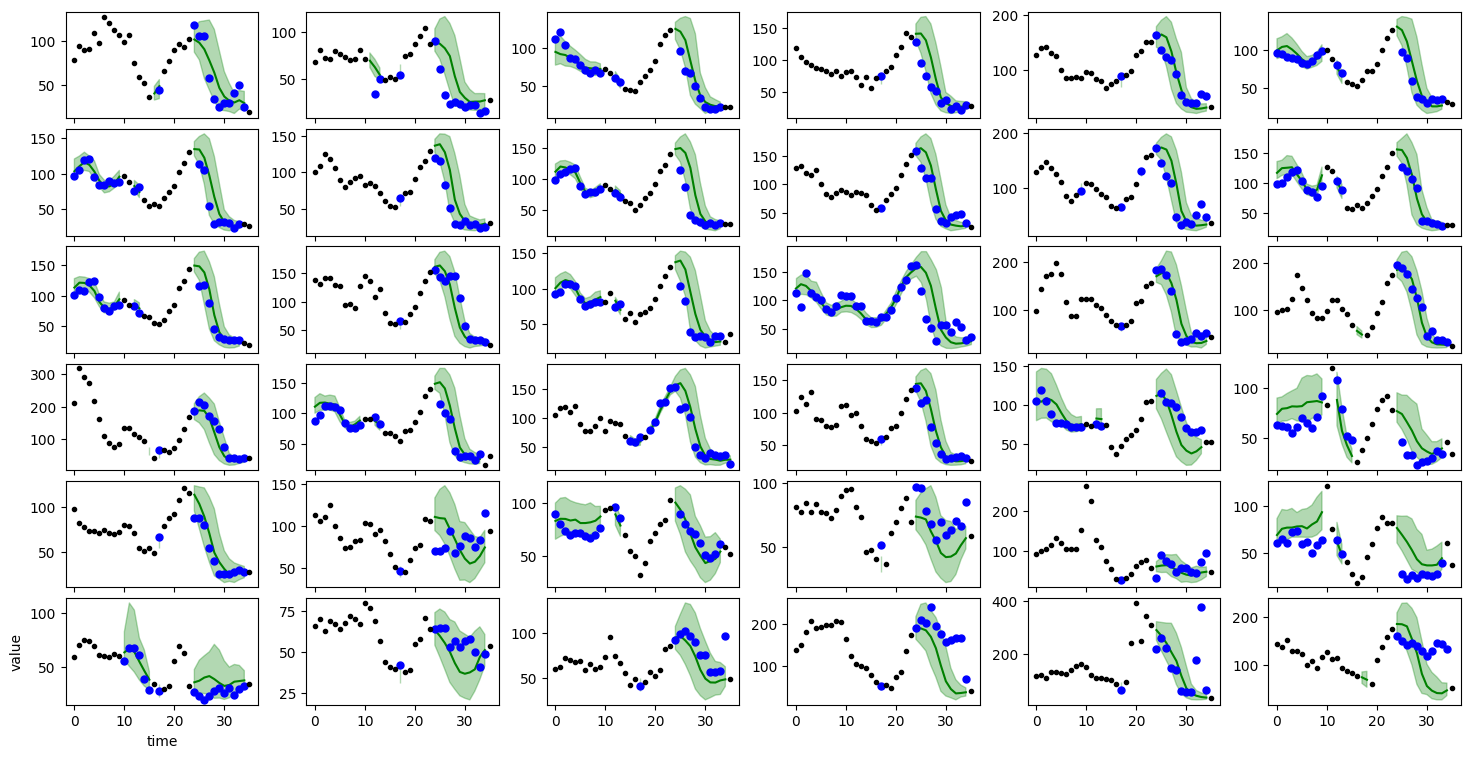

In [14]:
import util
ckpt_dir = './results/pm25_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_v2_10_12_2022_095150_ICML_eg/'
samples_path = ckpt_dir + 'generated_100_samples_05_22_2023_133008_corrector.pk'

dataind = 12
util.plot_saved_imputation_samples(samples_path, num_cols=6, dataind=dataind)
